In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import datetime as dt
%matplotlib inline

In [2]:
# FUNCTIONS YOU CAN USE:
#     analyses(filepath) spits out a nifty heatmap to let you check correlation between variables
#
#     regress(option, df) churns out a saucy graph of the linear regression for the variables you provided, where
#       option is 'snr_total' or 'tsnr', whichever you want to make the dependent variable of your model
#       df is the pandas DataFrame containing your data. To modify which variables you want in your model, you'll
#             have to directly modify the regress function

In [3]:
# NOTABLE FILENAMES
# ../data/extractions/p2_BOLD.csv                  - all dates for p2_BOLD
# ../data/extractions/p2Xs4X35mm_BOLD.csv          - all dates for p2Xs4X35mm_BOLD
# ../data/extractions/anat.csv                     - all possible dates for anatomical data

In [4]:
def filter(option, df):
    is_p2 = df['Filetype'] == "task-rest_acq-p2_bold.json"
    is_x = df['Filetype'] == "task-rest_acq-p2Xs4X35mm_bold.json"
    
    if option == 'x':
        return df[is_x]
    elif option == 'p2':
        return df[is_p2]

In [2]:
def analyses(filepath):
    files = pd.read_csv(filepath)
    
    # FIRST CHECK: CONVERSION SOFTWARE VERSIONS
    check = files.iloc[0, 7]
    valid = True
    
    for i in files.index:
        if check != files.iloc[i, 7]:
            valid = False
            
    print("All Conversion Softwares are the same: " + str(valid))
    
    # SECOND CHECK: HEATMAP
    sns.heatmap(files.corr(), cmap=sns.diverging_palette(h_neg=240, h_pos=10, n=9, sep=1, center="dark"), center=0)

In [20]:
def regress(target_variable, model_df, plot=True):
    # creates a regression graph plotted against actual data from certain QA metrics
    #      target_variable: takes str value of either snr_total or tsnr to model against
    #      model_df       : takes pandas DataFrame with data to be used for predictive modeling
    #      plot           : boolean to turn the plotted graph on/off
    
    ########## target_variable MUST be snr_total OR tsnr
    if target_variable != 'snr_total' and target_variable != 'tsnr' and target_variable != 'grey':
        return "Target variable must be snr_total, tsnr or grey"
    
    elif type(model_df) is not pd.core.frame.DataFrame:
        return "DataFrame must be of type pandas.core.frame.DataFrame"
    
    
    
    ########## adding seasonal curves to the model
    n = len(model_df)
    date = str(model_df.iat[0,0])
    values = [np.sin(np.pi*i/(26)) for i in range(n)]
    values2 = [np.cos(np.pi*i/(26)) for i in range(n)]
    dates = [dt.datetime(int(date[:4]), int(date[4:6]), int(date[6:])) + dt.timedelta(days = i*7) for i in range(n)]

    sin = pd.DataFrame(values)
    sin.columns = ['seasonal (sin)']
    
    cos = pd.DataFrame(values2)
    cos.columns = ['seasonal (cos)']
    
    model_df = model_df.join(sin)
    model_df = model_df.join(cos)
    
    
    
    ########## Converting date to a format that can be parsed by statsmodels API
    model_df['Date'] = pd.to_datetime(model_df['Date'], format="%Y%m%d")
    model_df['Date2'] = model_df['Date'].map(pd.datetime.toordinal)
    
    
    
    ########## Assigning independent and dependent variables
    model_vars = []
    
    for item in model_df.std().iteritems():
        if item[0] != 'Date' and item[0] != target_variable and item[1] != 0:
            model_vars.append(item[0])

    X = model_df[model_vars]
    X = sm.add_constant(X)
    y = model_df[target_variable]
    
    model_df = sm.add_constant(model_df)
    
    
    ########## modeling predictions
    model = sm.OLS(y, X).fit()
    predictions = model.predict(X)
    
    
    
    ################ CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    significant_variables = [] 
    
    # get p-values
    for key, value in dict(model.pvalues).items():
        if value < 0.05 or key.lower() == 'const':
            # identify statistically insignificant variables in df
            significant_variables.append(key)
    
    
    
    ######## set statistically insignificant variables to 0, then predict
        
    partial_fits = {}  # partial_fits = {}

    for variable in significant_variables:

        X2 = model_df.copy(True) # prepare for mods
        X2 = X2[model_vars]
        X2 = sm.add_constant(X2)

        for col in X2:
            if col != variable:
                X2[col] = 0
        
        partial_fits[str(variable)] = model.predict(X2)
        
    print("Statistically significant variables: " + str(significant_variables))
    
    ################ END CODE FOR TESTING INDIVIDUAL VARIABLE EFFECTS ####################
    
    if not plot:
        return model
    
    
    ######### converting the above predictions to a format that can be plotted
    
    plot_df = predictions.to_frame()       # new DataFrame containing only data needed for the plot
    plot_df.columns = ['full fit']
    plot_df = plot_df.join(model_df['Date'])
    plot_df = plot_df.join(model_df[target_variable])
    
    summation_df = None
    
    for key, value in partial_fits.items():
        column = value.to_frame()
        column.columns = ['partial fit']

        if summation_df is None:
            summation_df = column          # used to add up the values
        else:
            summation_df = summation_df.add(column, axis=1)
    
    plot_df = pd.concat([plot_df, summation_df], axis=1)
    
    # plotting the graph
    plt.figure(figsize=(15, 6))
    plt.style.use("dark_background")

    ax = sns.lineplot(x="Date", y=target_variable, data=plot_df, color="#000000")
    
    # plotting partial fit
    ax_partial = plt.twinx()
    sns.lineplot(x="Date", y="full fit", data=plot_df, color="r", ax=ax)
    sns.lineplot(x="Date", y="partial fit", data=plot_df, color="#ffcccc", ax=ax_partial)
    
    ax.legend(['actual', 'full fit'])
    ax_partial.legend(['partial fit'], loc='upper left')
    
    # giving additional data
    print(model.summary())
    
    if 'Shim1' and 'Shim2' and 'Shim3' and 'Shim4' and 'Shim5' and 'Shim6' and 'Shim7' and 'Shim8' in model_vars:
        print("Shim F-test: ")
        print(model.f_test("Shim1 = Shim2 = Shim3 = Shim4 = Shim5 = Shim6 = Shim7 = Shim8 = 0"))
    
    if 'IOPD1' and 'IOPD2' and 'IOPD3' and 'IOPD4' and 'IOPD5' and 'IOPD6' in model_vars:
        print("IOPD F-test: ")
        print(model.f_test("IOPD1 = IOPD2 = IOPD3 = IOPD4 = IOPD5 = IOPD6 = 0"))
    
    print("Seasonal F-test:")
    print(model.f_test("seasonal (sin) = seasonal (cos) = 0"))
    return model

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant variables: ['const', 'Shim6', 'seasonal (cos)']
                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.478
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     3.162
Date:                Mon, 13 May 2019   Prob (F-statistic):           0.000201
Time:                        15:50:47   Log-Likelihood:                -405.90
No. Observations:                  90   AIC:                             853.8
Df Residuals:                      69   BIC:                             906.3
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

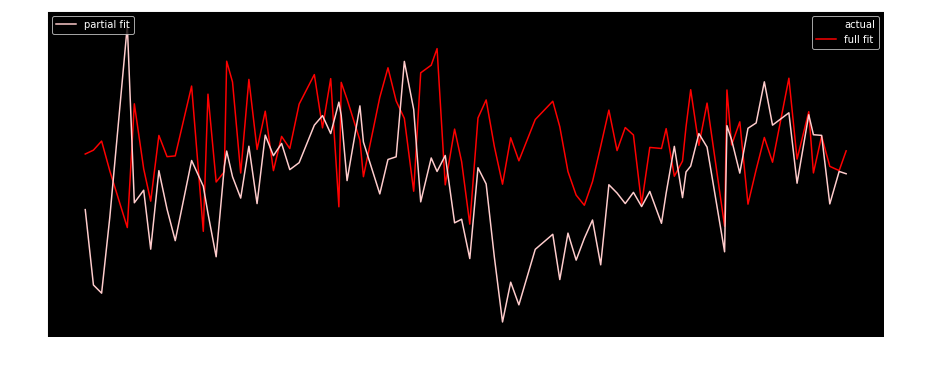

In [22]:
regress('tsnr', df)

All Conversion Softwares are the same: True


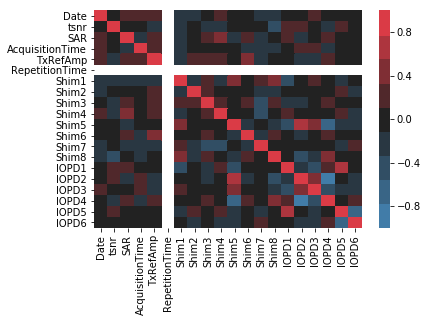

In [7]:
analyses('../data/extractions/p2_BOLD.csv')

All Conversion Softwares are the same: True


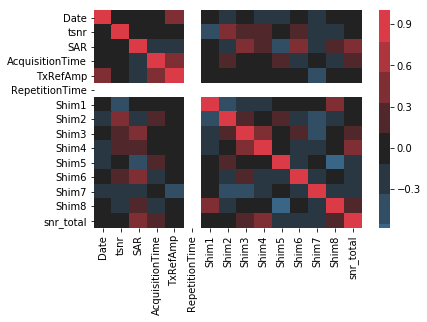

In [8]:
analyses('../data/extractions/p2_BOLD_snr.csv')

In [21]:
files = pd.read_csv('../data/extractions/p2_BOLD.csv')
df = pd.DataFrame(files,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

In [14]:
# p2Xs4X35mm_BOLD.csv
files2 = pd.read_csv('../data/extractions/p2Xs4X35mm_BOLD.csv')
df2 = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df2_shim = pd.DataFrame(files2,columns=['Date', 'tsnr', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df2_iopd = pd.DataFrame(files2,columns=['Date', 'tsnr', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df2_tx = pd.DataFrame(files2,columns=['Date', 'tsnr', 'TxRefAmp'])
# df2_AT = pd.DataFrame(files2,columns=['Date', 'tsnr', 'AcquisitionTime'])
# df2_SAR = pd.DataFrame(files2,columns=['Date', 'tsnr', 'SAR'])
# df2_RT = pd.DataFrame(files2,columns=['Date', 'tsnr', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant parameters: ['Shim5', 'Shim6']
                            OLS Regression Results                            
Dep. Variable:                   tsnr   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     4.440
Date:                Mon, 29 Apr 2019   Prob (F-statistic):           1.45e-06
Time:                        12:47:04   Log-Likelihood:                -383.11
No. Observations:                  90   AIC:                             810.2
Df Residuals:                      68   BIC:                             865.2
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

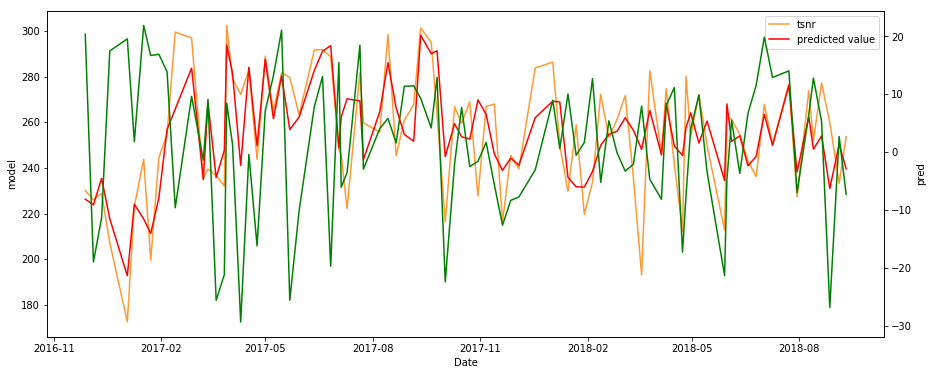

In [18]:
regress('tsnr', df2)

In [6]:
files3 = pd.read_csv('../data/extractions/anat.csv')
df3 = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2', 'IOPD3', 'IOPD4',
                                'IOPD5', 'IOPD6'])
df3['Date'] = pd.to_datetime(df3['Date'], format="%Y%m%d")
df3.set_index('Date',inplace=True)
# df3_shim = pd.DataFrame(files3,columns=['Date', 'snr_total', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
#                                 'Shim5', 'Shim6', 'Shim7', 'Shim8'])
# df3_iopd = pd.DataFrame(files3,columns=['Date', 'snr_total', 'IOPD1', 'IOPD2',
#                                 'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])
# df3_tx = pd.DataFrame(files3,columns=['Date', 'snr_total', 'TxRefAmp'])
# df3_AT = pd.DataFrame(files3,columns=['Date', 'snr_total', 'AcquisitionTime'])
# df3_SAR = pd.DataFrame(files3,columns=['Date', 'snr_total', 'SAR'])
# df3_RT = pd.DataFrame(files3,columns=['Date', 'snr_total', 'RepetitionTime'])

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


Statistically significant parameters: ['AcquisitionTime', 'SAR']
                            OLS Regression Results                            
Dep. Variable:              snr_total   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     3.194
Date:                Mon, 29 Apr 2019   Prob (F-statistic):            0.00455
Time:                        12:47:31   Log-Likelihood:                -86.977
No. Observations:                  44   AIC:                             200.0
Df Residuals:                      31   BIC:                             223.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

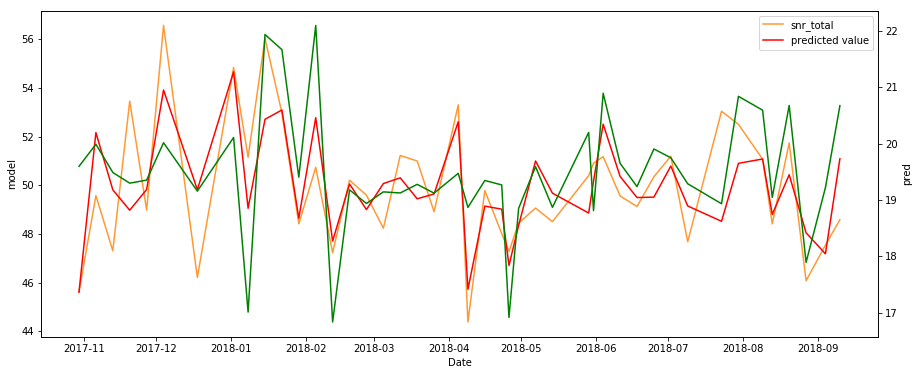

In [20]:
regress('snr_total', df3)

In [4]:
real_files = pd.read_csv('../output/real_output.csv')
real_df = pd.DataFrame(real_files,columns=['Date', 'sid', 'ses', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

segstats = pd.read_csv('../output/segstats-volume.csv')
seg_df = pd.DataFrame(segstats,columns=['Date', 'sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"])
merged_df = pd.merge(real_df, seg_df, on=['sid', 'ses'], how='outer')
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], format="%Y%m%d")
merged_df.set_index('Date_x',inplace=True)
merged_df

,sid,ses,snr_total,TxRefAmp,AcquisitionTime,SAR,RepetitionTime,Shim1,Shim2,Shim3,...,Right-Accumbens-area,Right-Amygdala,Right-Caudate,Right-Hippocampus,Right-Pallidum,Right-Putamen,Right-Thalamus-Proper,csf,gray,white
Date_x,,,,,,,,,,,,,,,,,,,,,
2016-10-11,sub-sid000003,20161011X092931,12.176199,228.321,34773,0.046610,2.30,4153,-7690,-7492,...,442.968783,1688.027471,3268.476809,3543.750267,1760.800914,4587.099955,7838.965434,292997.718750,8.496853e+05,6.136589e+05
2017-02-14,sub-sid000005,20170214X120812,11.995018,258.474,44480,0.057880,2.30,4153,-7690,-7492,...,635.185595,1718.877083,4169.443674,4436.806975,1953.808741,5039.560927,8996.221381,279086.937500,9.059462e+05,7.412118e+05
2017-08-28,sub-sid000005,20170828X155317,13.083898,257.477,58313,0.059600,2.30,4153,-7690,-7492,...,594.052779,1803.515761,4095.088199,4337.930014,1979.912259,4977.070688,9061.084667,248674.781250,7.889210e+05,6.653368e+05
2017-08-29,sub-sid000005,20170829X171624,13.052024,265.239,62795,0.064612,2.30,4153,-7690,-7492,...,627.275438,1688.027471,4095.088199,4511.162449,1949.853663,5339.355871,9176.572957,281862.593750,8.714904e+05,7.198607e+05
2017-11-18,sub-sid000005,20171118X174426,13.184153,255.721,63930,0.055096,2.30,4146,-7686,-7488,...,621.738328,1703.847785,4100.625309,4282.558916,2001.269682,4947.012092,9038.936228,278994.406250,9.293572e+05,7.293204e+05
2017-02-13,sub-sid000007,20170213X131037,13.696513,253.806,48368,0.053773,2.30,4153,-7690,-7492,...,473.027379,1378.740338,3405.322522,4232.724928,1962.509914,5410.547283,9499.307356,214801.890625,7.374070e+05,6.415477e+05
2017-09-30,sub-sid000007,20170930X101910,12.540846,273.768,37228,0.070596,2.30,4146,-7686,-7488,...,435.849642,1431.738389,3410.068616,4318.945638,1967.256008,5504.678149,9863.965587,258066.468750,8.113044e+05,6.960376e+05
2017-10-04,sub-sid000007,20171004X101244,13.773062,264.229,36827,0.064534,2.30,4146,-7686,-7488,...,488.847693,1539.316522,3390.293224,4352.959312,1933.242333,5604.346125,9555.469470,248599.625000,8.340438e+05,6.870493e+05
2017-11-13,sub-sid000007,20171113X193049,13.851964,271.448,70745,0.068664,2.30,4146,-7686,-7488,...,491.220740,1546.435663,3423.515883,4352.959312,1979.912259,5609.092220,9606.094474,314915.968750,9.380308e+05,8.300230e+05


In [7]:
df_reindexed = df3.reindex(pd.date_range(start=df3.index.min(), end=df3.index.max(), freq='1D'))  
df_reindexed.index.names = ['Date_x']
interpolated_df = df_reindexed.interpolate(method='time')
interpolated_df

,snr_total,TxRefAmp,AcquisitionTime,SAR,RepetitionTime,Shim1,Shim2,Shim3,Shim4,Shim5,Shim6,Shim7,Shim8,IOPD1,IOPD2,IOPD3,IOPD4,IOPD5,IOPD6
Date_x,,,,,,,,,,,,,,,,,,,
2017-10-30,45.609948,230.573000,39009.000000,0.033092,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
2017-10-31,46.176395,230.703571,39409.714286,0.033102,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596
2017-11-01,46.742842,230.834143,39810.428571,0.033112,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411
2017-11-02,47.309289,230.964714,40211.142857,0.033121,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.554171,0.531484,0.138956,-0.122010,0.678457,-0.309418
2017-11-03,47.875736,231.095286,40611.857143,0.033131,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425
2017-11-04,48.442183,231.225857,41012.571429,0.033141,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.272647,0.742449,0.220246,-0.060225,0.490009,-0.631432
2017-11-05,49.008630,231.356429,41413.285714,0.033150,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439
2017-11-06,49.575077,231.487000,41814.000000,0.033160,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,-0.008877,0.953414,0.301535,0.001560,0.301560,-0.953446
2017-11-07,49.251327,231.464000,41217.428571,0.033173,2.3,4146.0,-7686.0,-7488.0,192.0,-55.0,-88.0,-63.0,64.0,-0.028902,0.951493,0.302313,-0.007970,0.301400,-0.953178


In [18]:
super_df = pd.merge(merged_df, interpolated_df, left_index=True, right_index=True, suffixes = ("_real", "_qa"))
super_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,Shim5_qa,Shim6_qa,Shim7_qa,Shim8_qa,IOPD1_qa,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,-55.0,-88.0,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439


In [19]:
demographic_df = pd.read_csv('../data/dbic/bids/participants.tsv', sep='\t')
demographic_df = demographic_df.rename(index=str, columns={"participant_id": "sid"})
final_df = super_df.join(demographic_df.set_index('sid'), on='sid', how='left')
final_df

,sid,ses,snr_total_real,TxRefAmp_real,AcquisitionTime_real,SAR_real,RepetitionTime_real,Shim1_real,Shim2_real,Shim3_real,...,Shim7_qa,Shim8_qa,IOPD1_qa,IOPD2_qa,IOPD3_qa,IOPD4_qa,IOPD5_qa,IOPD6_qa,age,sex
Date_x,,,,,,,,,,,,,,,,,,,,,
2017-10-30,sub-sid000496,20171030X191622,11.073170,301.097,69686,0.053360,2.3,4146,-7686,-7488,...,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,18,M
2017-10-30,sub-sid000671,20171030X201904,13.257334,239.409,73440,0.056120,2.3,4146,-7686,-7488,...,-63.0,64.0,0.976457,0.215037,0.017022,-0.214688,0.961130,0.173603,19,M
2017-10-31,sub-sid000013,20171031X200034,12.908929,228.607,72731,0.047360,2.3,4146,-7686,-7488,...,-63.0,64.0,0.835695,0.320519,0.057667,-0.183795,0.866906,0.012596,27,F
2017-11-01,sub-sid000009,20171101X195906,12.986074,246.713,72619,0.055586,2.3,4146,-7686,-7488,...,-63.0,64.0,0.694933,0.426002,0.098311,-0.152903,0.772681,-0.148411,27,M
2017-11-03,sub-sid000677,20171103X190009,11.148881,244.822,68937,0.057679,2.3,4146,-7686,-7488,...,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,19,F
2017-11-03,sub-sid000678,20171103X200909,14.231328,226.757,73221,0.051241,2.3,4146,-7686,-7488,...,-63.0,64.0,0.413409,0.636967,0.179601,-0.091118,0.584233,-0.470425,21,F
2017-11-05,sub-sid000024,20171105X200345,12.615811,268.301,72794,0.058591,2.3,4146,-7686,-7488,...,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,31,M
2017-11-05,sub-sid000494,20171105X121747,13.041954,250.491,44508,0.065390,2.3,4146,-7686,-7488,...,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,18,F
2017-11-05,sub-sid000679,20171105X100749,11.297897,226.806,36978,0.056067,2.3,4146,-7686,-7488,...,-63.0,64.0,0.131885,0.847932,0.260890,-0.029333,0.395784,-0.792439,19,F


In [ ]:
final_df.iloc[:, 1:4]